In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
#from scipy.fft import fft, ifft
from scipy.signal import periodogram, find_peaks

In [3]:
df = pd.read_csv("./data/DayAheadSpotPrices.csv")
df.head()

,Unnamed: 0,2017,2030,2017 (MO),2030 (MO),Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1,20.96,70.650,-83.06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20.90,59.277,-83.04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,18.13,47.834,-83.03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,16.03,44.602,-83.02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,16.43,37.968,-83.01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
drop_list = ['2030', '2017 (MO)', '2030 (MO)', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']
df.drop(drop_list, inplace = True, axis = 1)
df.head()

,Unnamed: 0,2017
0,1,20.96
1,2,20.90
2,3,18.13
3,4,16.03
4,5,16.43


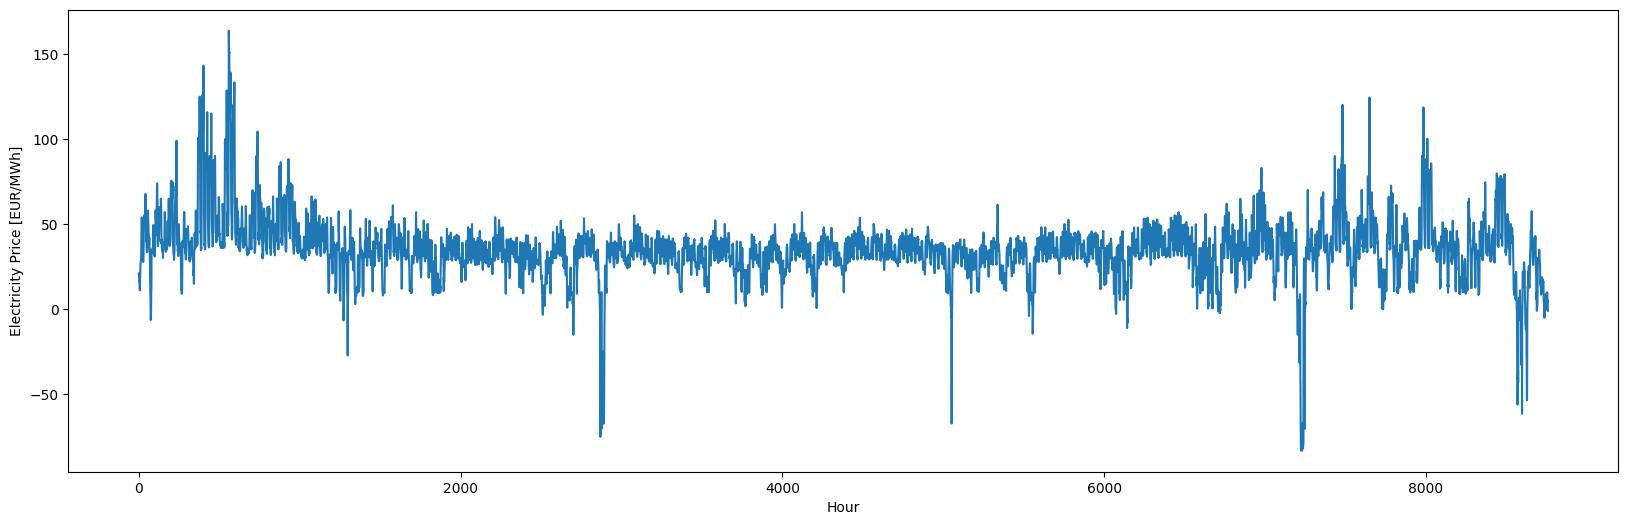

In [5]:
#plot raw data
y = df['2017'].values
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(y)
ax.set_ylabel('Electricity Price [EUR/MWh]')
ax.set_xlabel('Hour')
plt.savefig("Raw Data", dpi = 400)

In [11]:
#separate data by seasons for better visualization
winter = df['2017'][0:1416] #feb 28
spring = df['2017'][1416:3624] #may 31
summer = df['2017'][3624:5832] #aug 31
fall = df['2017'][5832:8761] #dec 31

(5832.0, 8759.0)

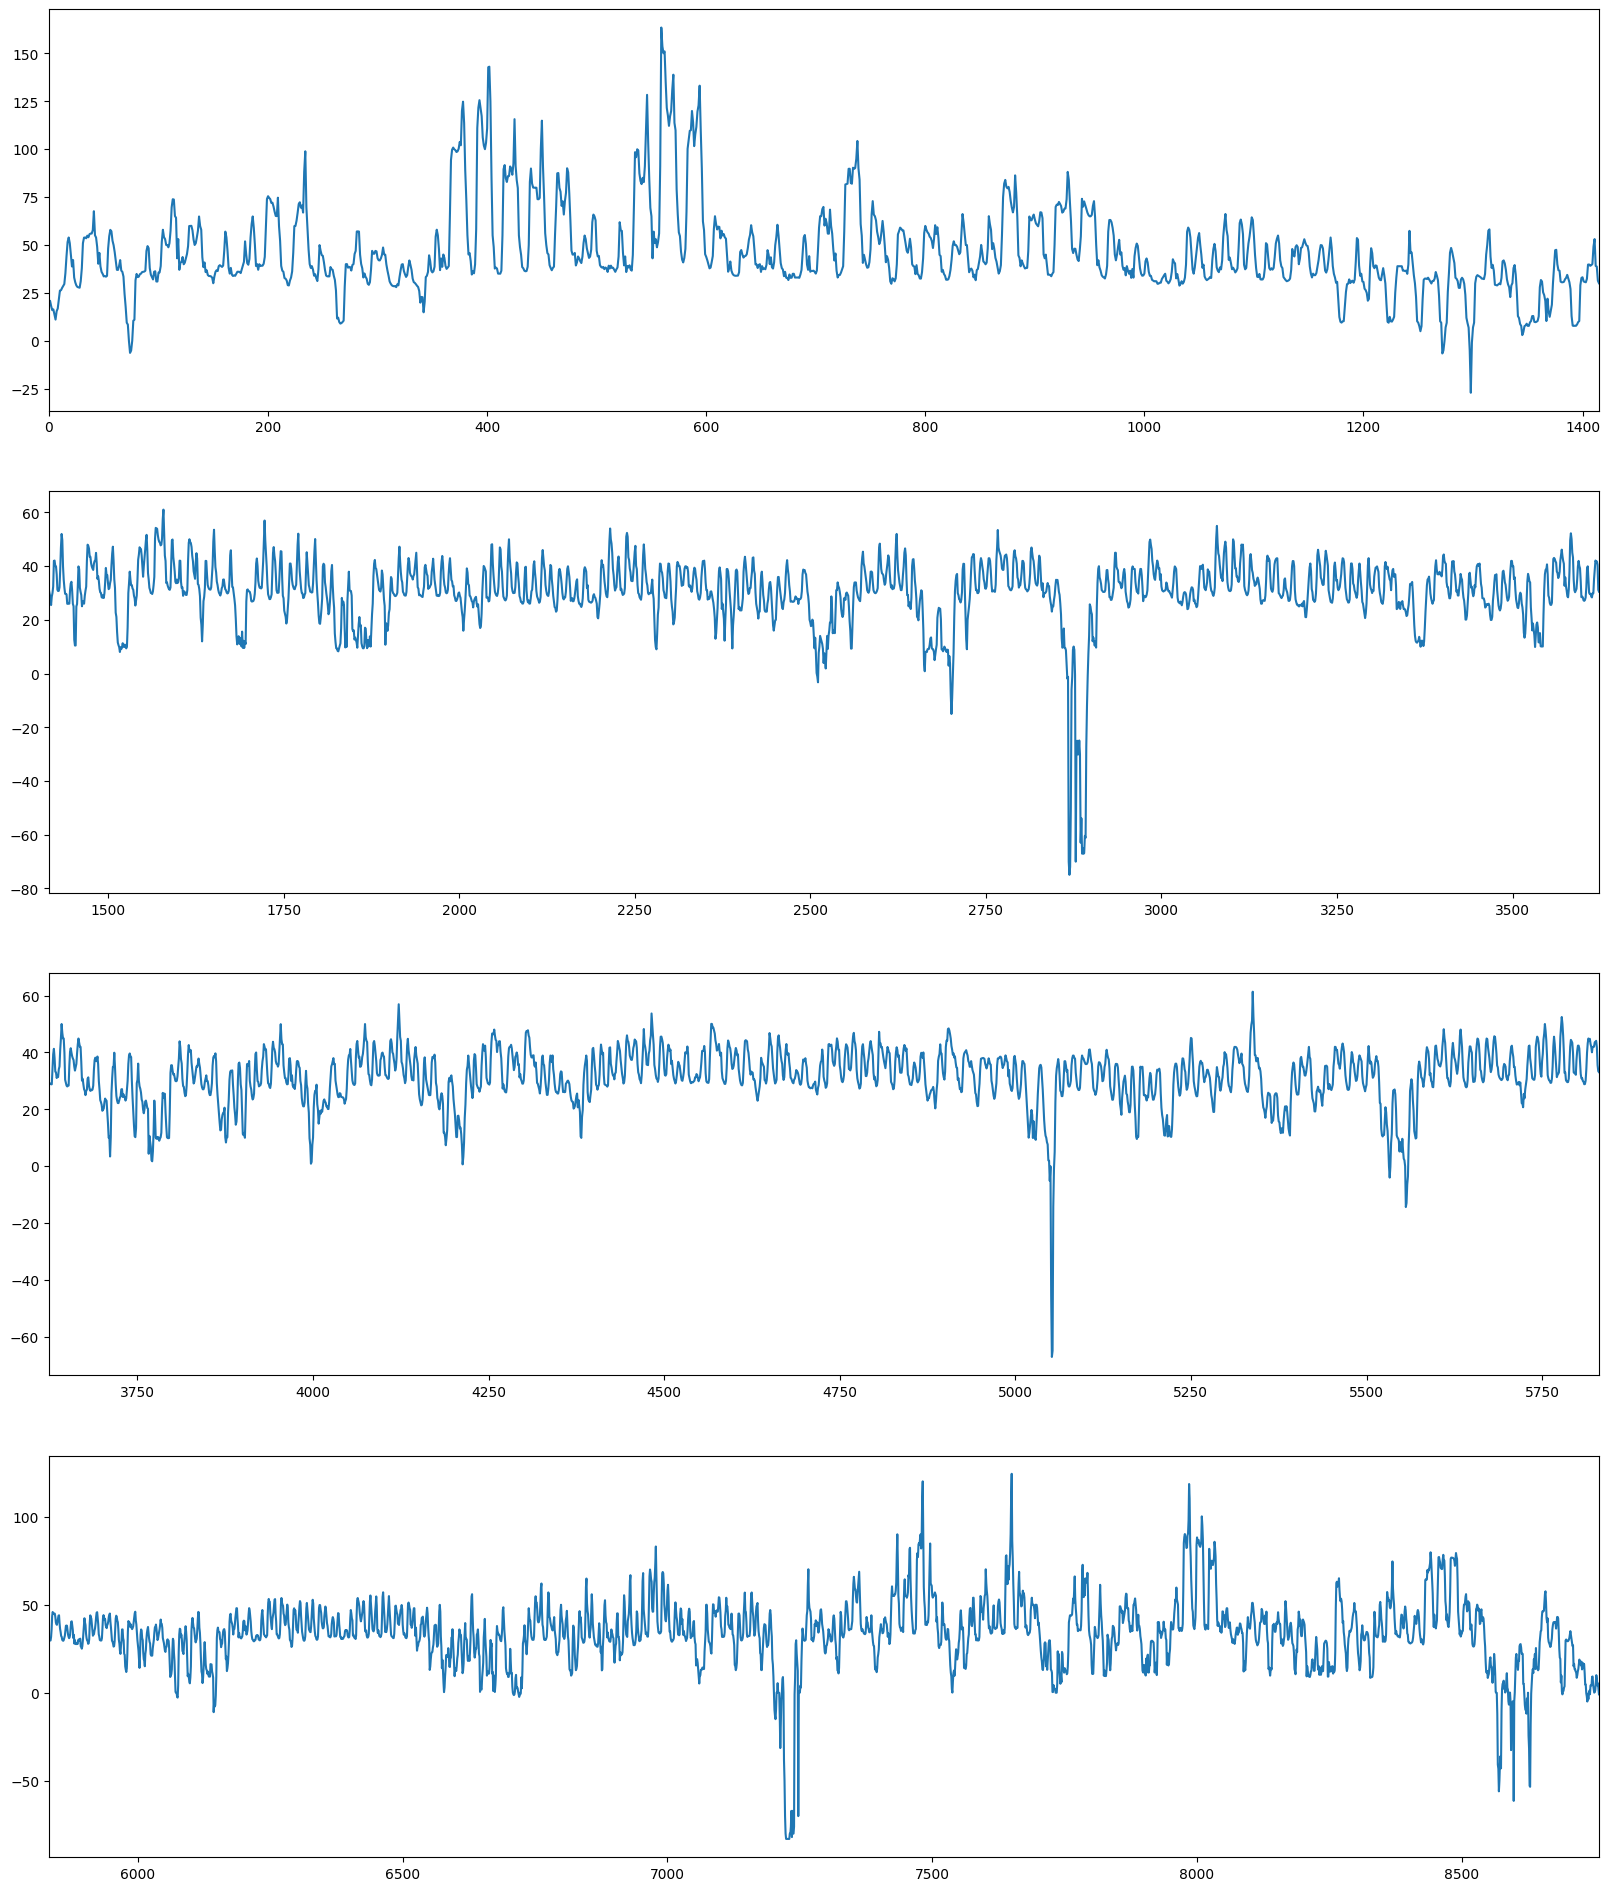

In [71]:
fig, ax = plt.subplots(4,1, figsize = (20,24))
ax[0].plot(range(0, 1416), winter.values)
ax[0].set_xlim([0, 1415])
ax[1].plot(range(1416, 3624), spring.values)
ax[1].set_xlim([1416, 3623])
ax[2].plot(range(3624, 5832), summer.values)
ax[2].set_xlim([3624, 5831])
ax[3].plot(range(5832, 8760), fall.values)
ax[3].set_xlim([5832, 8759])

### Exploring Fourier

In [72]:
#DFT
X = fft.fft(df['2017'])
N = len(X)
frequencies = fft.fftfreq(N, 1)
periods = 1 / frequencies
fft_magnitude = np.abs(X) / N

mask = frequencies >= 0

/var/folders/yt/vy489wg91230n1q109cqfkdr0000gn/T/ipykernel_54523/2589901552.py:5: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


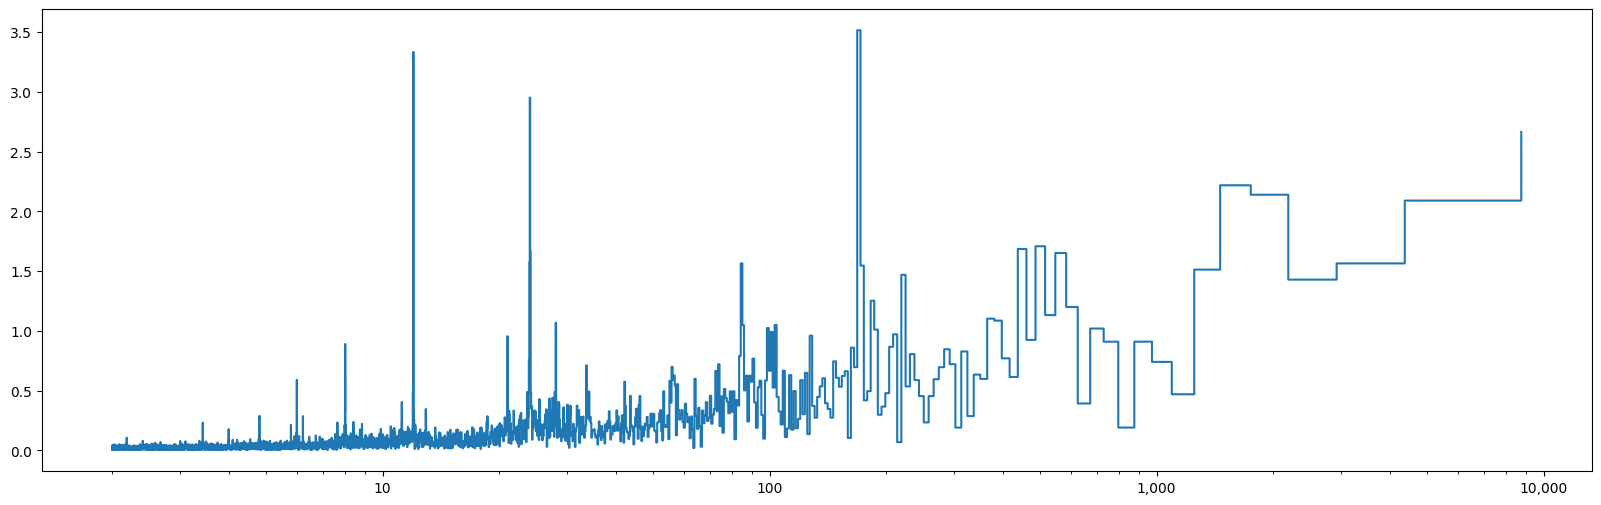

In [73]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.step(periods[mask], fft_magnitude[mask])
ax.set_xscale('log')
ax.xaxis.set_major_formatter('{x:,.0f}')

/var/folders/yt/vy489wg91230n1q109cqfkdr0000gn/T/ipykernel_54523/472809682.py:3: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


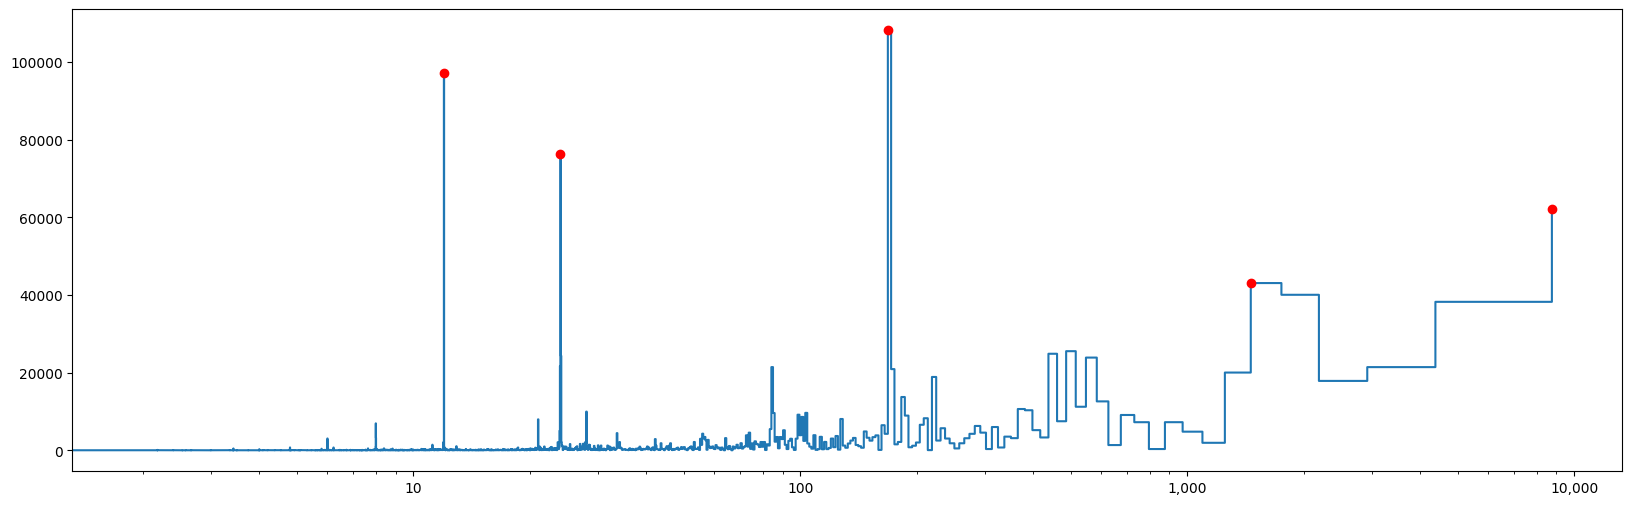

In [75]:
#fourier transform, highlight peaks
frequencies, power_spectrum = periodogram(df['2017'], return_onesided = False)
periods = 1 / frequencies

peaks, _ = find_peaks(power_spectrum)

peak_periods = periods[peaks]
peak_values = power_spectrum[peaks]

threshold = 40000

large_peaks = peak_values > threshold
large_periods = peak_periods[large_peaks]
large_peak_values = peak_values[large_peaks]

large_peak_freq = 1 / large_periods

fig, ax = plt.subplots(figsize = (20,6))
ax.step(periods, power_spectrum)
ax.set_xscale('log')
ax.xaxis.set_major_formatter('{x:,.0f}')
ax.plot(large_periods, large_peak_values, 'ro')

In [76]:
print(large_peak_values)

[ 62185.2657459   43085.42945113 108217.67254523  76290.31231985
  97321.91148606  97321.91148606  76290.31231985 108217.67254523
  43085.42945113]


In [78]:
#try to extract large peak values
for large_peak_frequency in large_peak_freq:
    peak_index = np.argmin(np.abs(frequencies[mask] - large_peak_frequency))
    
    original_index = peak_index
    original_value = df['2017'].iloc[original_index]

    print(f"Frequency {large_peak_frequency:.2f} Hz corresponds to Time-Series Data Point: Index: {original_index}, Value: {original_value}")

Frequency 0.00 Hz corresponds to Time-Series Data Point: Index: 1, Value: 20.9
Frequency 0.00 Hz corresponds to Time-Series Data Point: Index: 6, Value: 11.1
Frequency 0.01 Hz corresponds to Time-Series Data Point: Index: 52, Value: 33.5
Frequency 0.04 Hz corresponds to Time-Series Data Point: Index: 365, Value: 39.06
Frequency 0.08 Hz corresponds to Time-Series Data Point: Index: 730, Value: 89.8
Frequency -0.08 Hz corresponds to Time-Series Data Point: Index: 0, Value: 20.96
Frequency -0.04 Hz corresponds to Time-Series Data Point: Index: 0, Value: 20.96
Frequency -0.01 Hz corresponds to Time-Series Data Point: Index: 0, Value: 20.96
Frequency -0.00 Hz corresponds to Time-Series Data Point: Index: 0, Value: 20.96


### STL Decomposition

In [6]:
from prophet import Prophet

15:07:43 - cmdstanpy - INFO - Chain [1] start processing
15:07:43 - cmdstanpy - INFO - Chain [1] done processing


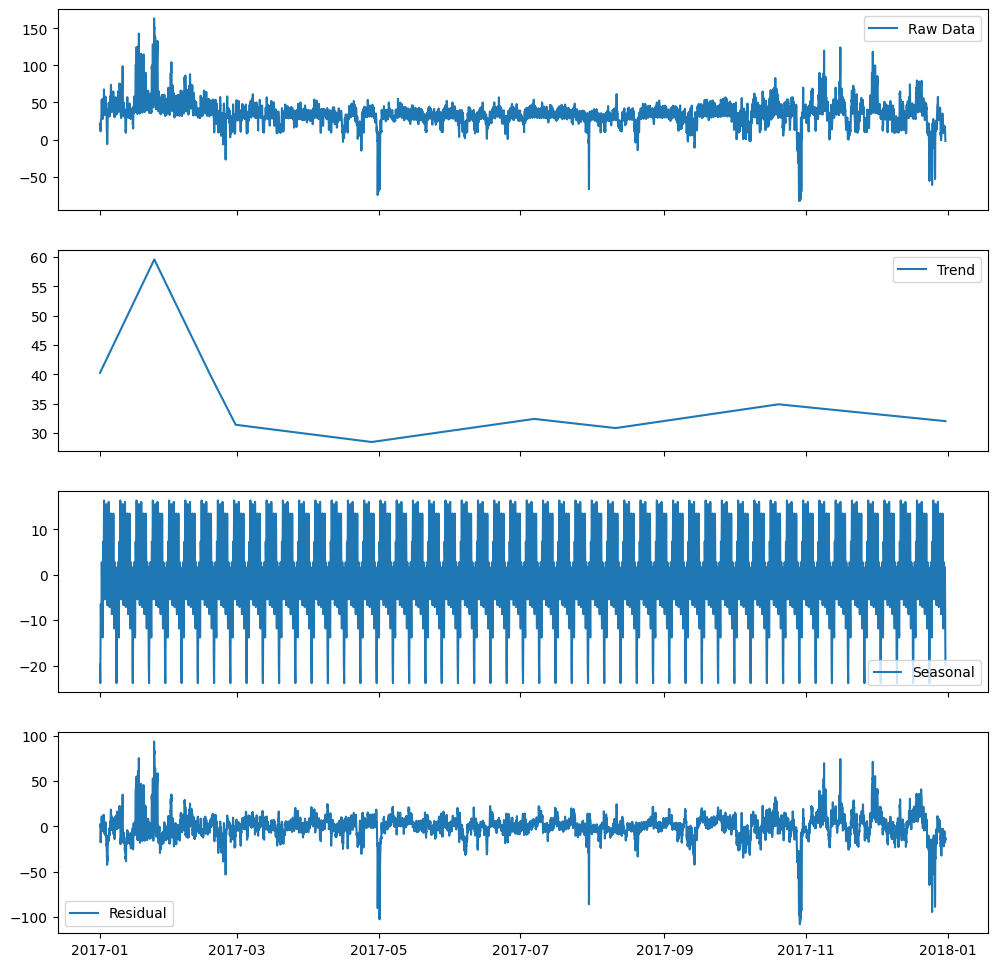

In [9]:
#STL on entire series
df_p = pd.DataFrame({
    'ds': pd.date_range('2017-01-01', periods=365*24, freq='H'),
    'y': df['2017'].values
})

model = Prophet()
model.fit(df_p)

future = model.make_future_dataframe(periods = 365*24)

forecast = model.predict(future)

components = forecast[['ds', 'yhat', 'trend', 'additive_terms']]

start_date = '2017-01-01'
end_date = '2017-12-31'

forecast_2017 = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
df_p_2017 = df_p[(df_p['ds'] >= start_date) & (df_p['ds'] <= end_date)]

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex = True)

ax[0].plot(df_p_2017['ds'], df_p_2017['y'], label = 'Raw Data')
ax[0].legend()

ax[1].plot(forecast_2017['ds'], forecast_2017['trend'], label = 'Trend')
ax[1].legend()

ax[2].plot(forecast_2017['ds'], forecast_2017['additive_terms'], label = 'Seasonal')
ax[2].legend()

hist_forecast = forecast_2017[:len(df_p)]
residuals = df_p_2017['y'].values - hist_forecast['yhat']
ax[3].plot(df_p_2017['ds'], residuals, label = 'Residual')
ax[3].legend()

plt.show()

In [12]:
print(len(winter))
print(len(spring))
print(len(summer))
print(len(fall))

1416
2208
2208
2928


15:08:19 - cmdstanpy - INFO - Chain [1] start processing
15:08:19 - cmdstanpy - INFO - Chain [1] done processing


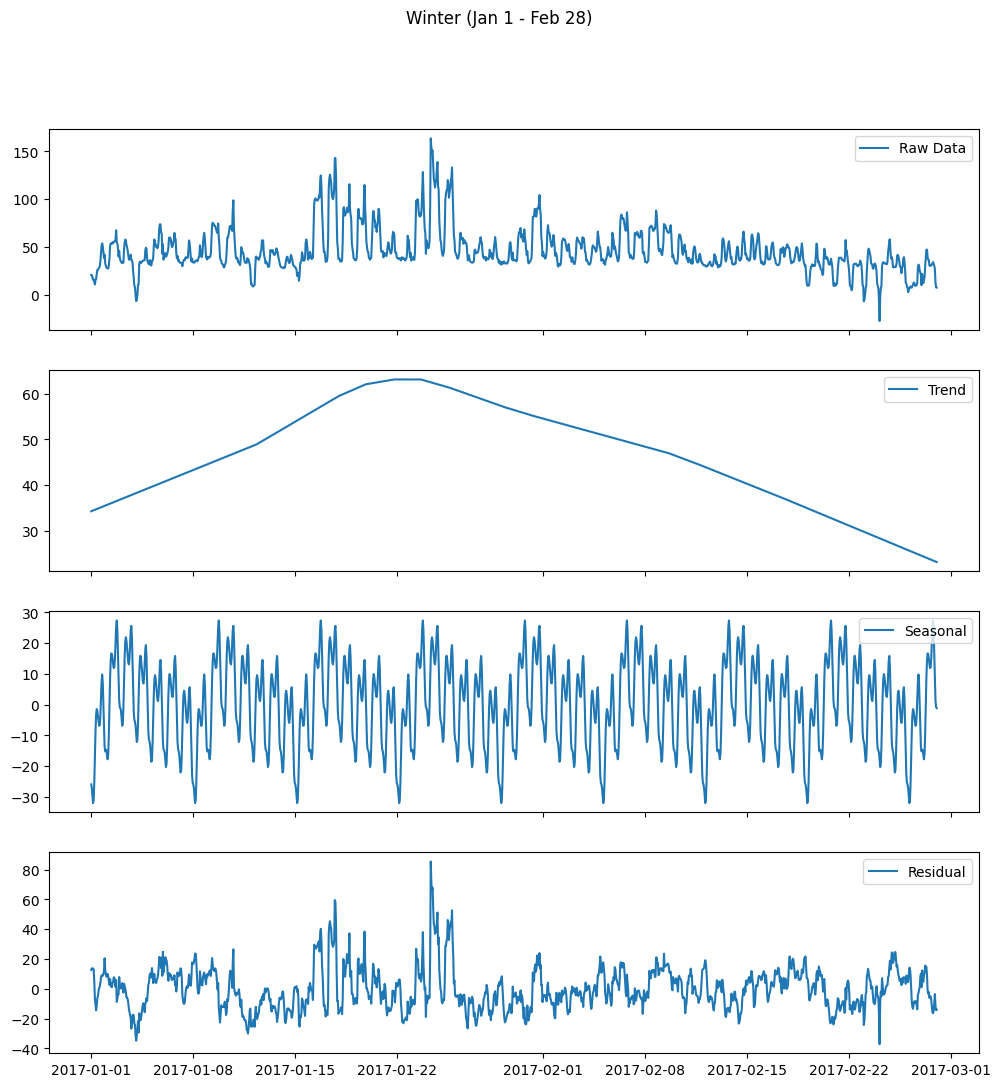

In [13]:
df_p = pd.DataFrame({
    'ds': pd.date_range('2017-01-01', periods=1416, freq='H'),
    'y': winter.values
})

model = Prophet()
model.fit(df_p)

future = model.make_future_dataframe(periods = 1416)

forecast = model.predict(future)

components = forecast[['ds', 'yhat', 'trend', 'additive_terms']]

start_date = '2017-01-01'
end_date = '2017-02-28'

forecast_2017 = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
df_p_2017 = df_p[(df_p['ds'] >= start_date) & (df_p['ds'] <= end_date)]

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex = True)

ax[0].plot(df_p_2017['ds'], df_p_2017['y'], label = 'Raw Data')
ax[0].legend()

ax[1].plot(forecast_2017['ds'], forecast_2017['trend'], label = 'Trend')
ax[1].legend()

ax[2].plot(forecast_2017['ds'], forecast_2017['additive_terms'], label = 'Seasonal')
ax[2].legend()

hist_forecast = forecast_2017[:len(df_p)]
residuals = df_p_2017['y'].values - hist_forecast['yhat']
ax[3].plot(df_p_2017['ds'], residuals, label = 'Residual')
ax[3].legend()
plt.suptitle("Winter (Jan 1 - Feb 28)")

plt.show()

15:08:30 - cmdstanpy - INFO - Chain [1] start processing
15:08:30 - cmdstanpy - INFO - Chain [1] done processing


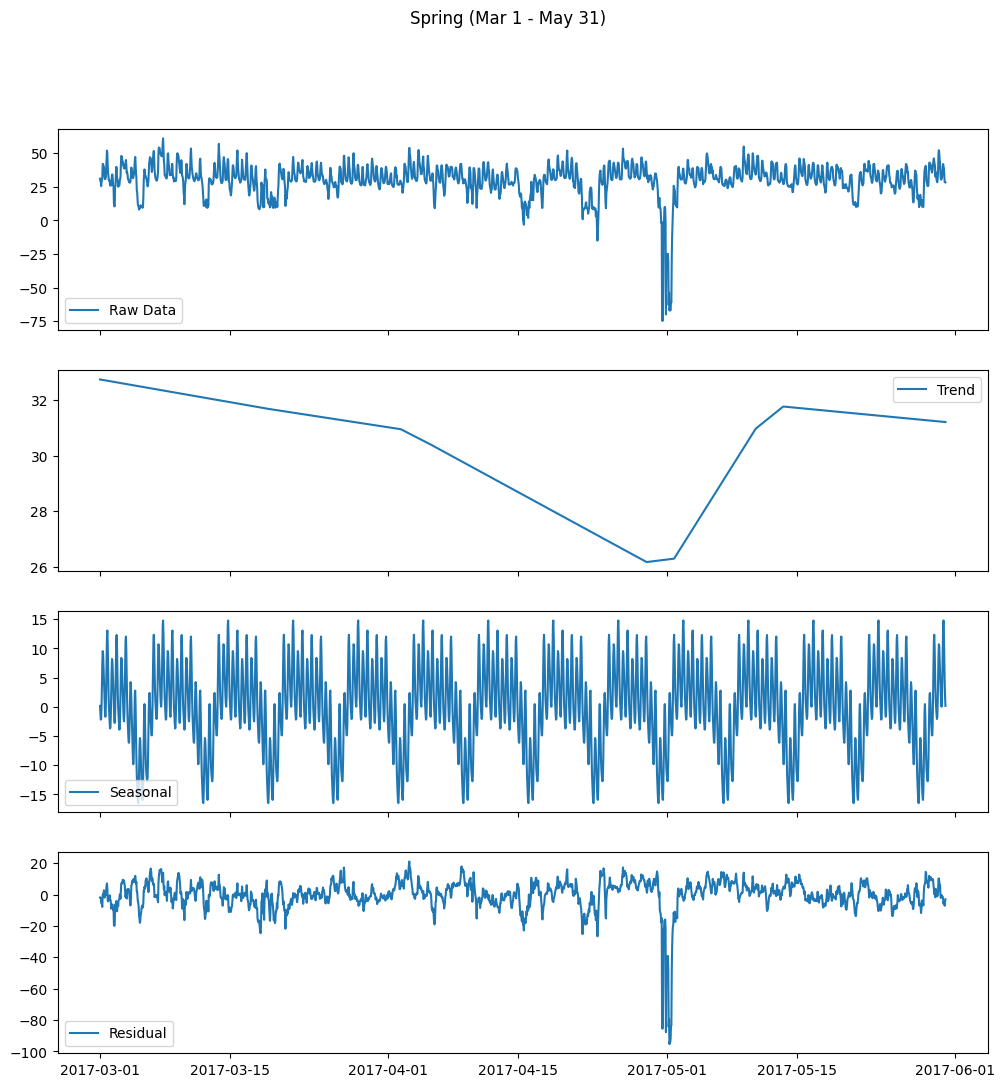

In [14]:
df_p = pd.DataFrame({
    'ds': pd.date_range('2017-03-01', periods=2208, freq='H'),
    'y': spring.values
})

model = Prophet()
model.fit(df_p)

future = model.make_future_dataframe(periods = 2208)

forecast = model.predict(future)

components = forecast[['ds', 'yhat', 'trend', 'additive_terms']]

start_date = '2017-03-01'
end_date = '2017-05-31'

forecast_2017 = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
df_p_2017 = df_p[(df_p['ds'] >= start_date) & (df_p['ds'] <= end_date)]

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex = True)

ax[0].plot(df_p_2017['ds'], df_p_2017['y'], label = 'Raw Data')
ax[0].legend()

ax[1].plot(forecast_2017['ds'], forecast_2017['trend'], label = 'Trend')
ax[1].legend()

ax[2].plot(forecast_2017['ds'], forecast_2017['additive_terms'], label = 'Seasonal')
ax[2].legend()

hist_forecast = forecast_2017[:len(df_p)]
residuals = df_p_2017['y'].values - hist_forecast['yhat']
ax[3].plot(df_p_2017['ds'], residuals, label = 'Residual')
ax[3].legend()
plt.suptitle("Spring (Mar 1 - May 31)")

plt.show()

15:08:34 - cmdstanpy - INFO - Chain [1] start processing
15:08:34 - cmdstanpy - INFO - Chain [1] done processing


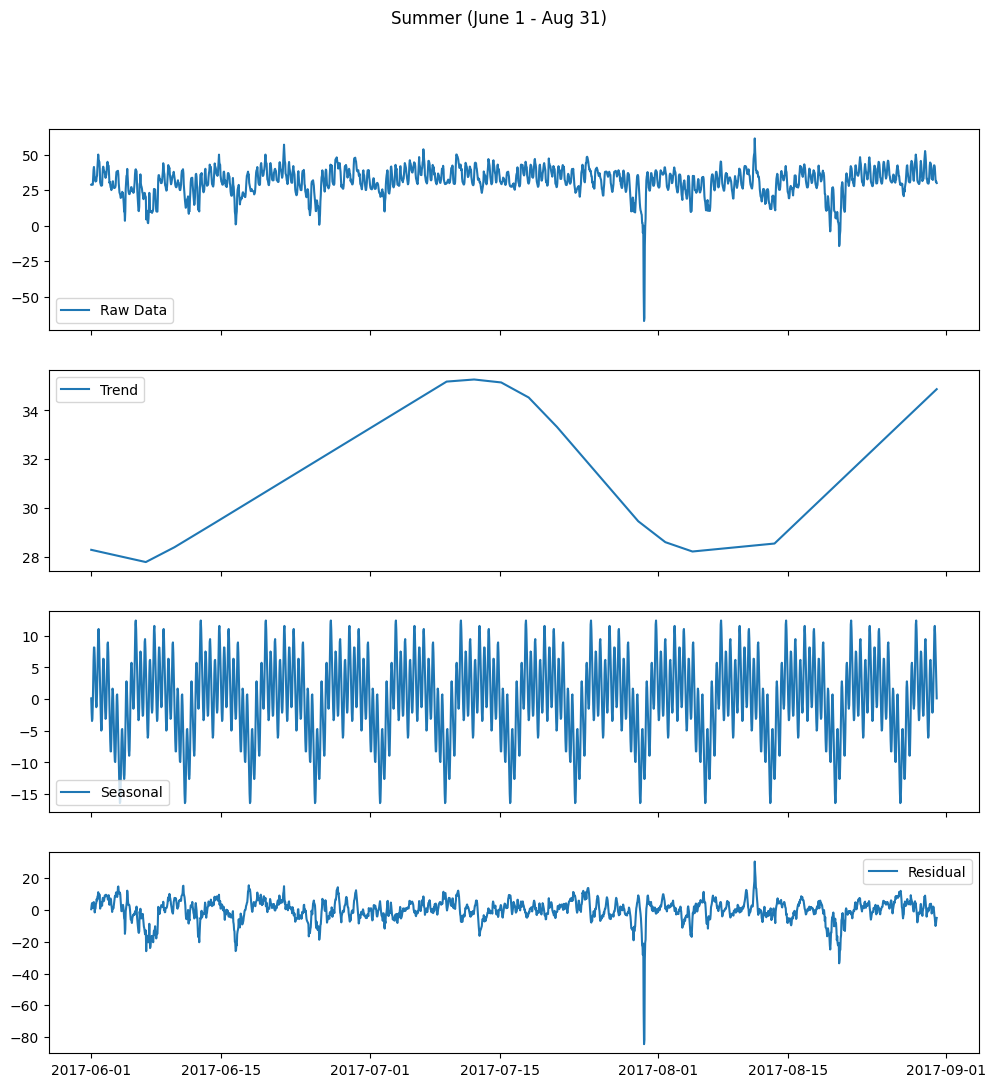

In [15]:
df_p = pd.DataFrame({
    'ds': pd.date_range('2017-06-01', periods=2208, freq='H'),
    'y': summer.values
})

model = Prophet()
model.fit(df_p)

future = model.make_future_dataframe(periods = 2208)

forecast = model.predict(future)

components = forecast[['ds', 'yhat', 'trend', 'additive_terms']]

start_date = '2017-06-01'
end_date = '2017-08-31'

forecast_2017 = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
df_p_2017 = df_p[(df_p['ds'] >= start_date) & (df_p['ds'] <= end_date)]

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex = True)

ax[0].plot(df_p_2017['ds'], df_p_2017['y'], label = 'Raw Data')
ax[0].legend()

ax[1].plot(forecast_2017['ds'], forecast_2017['trend'], label = 'Trend')
ax[1].legend()

ax[2].plot(forecast_2017['ds'], forecast_2017['additive_terms'], label = 'Seasonal')
ax[2].legend()

hist_forecast = forecast_2017[:len(df_p)]
residuals = df_p_2017['y'].values - hist_forecast['yhat']
ax[3].plot(df_p_2017['ds'], residuals, label = 'Residual')
ax[3].legend()
plt.suptitle("Summer (June 1 - Aug 31)")

plt.show()

09:30:38 - cmdstanpy - INFO - Chain [1] start processing
python(62451) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
09:30:38 - cmdstanpy - INFO - Chain [1] done processing


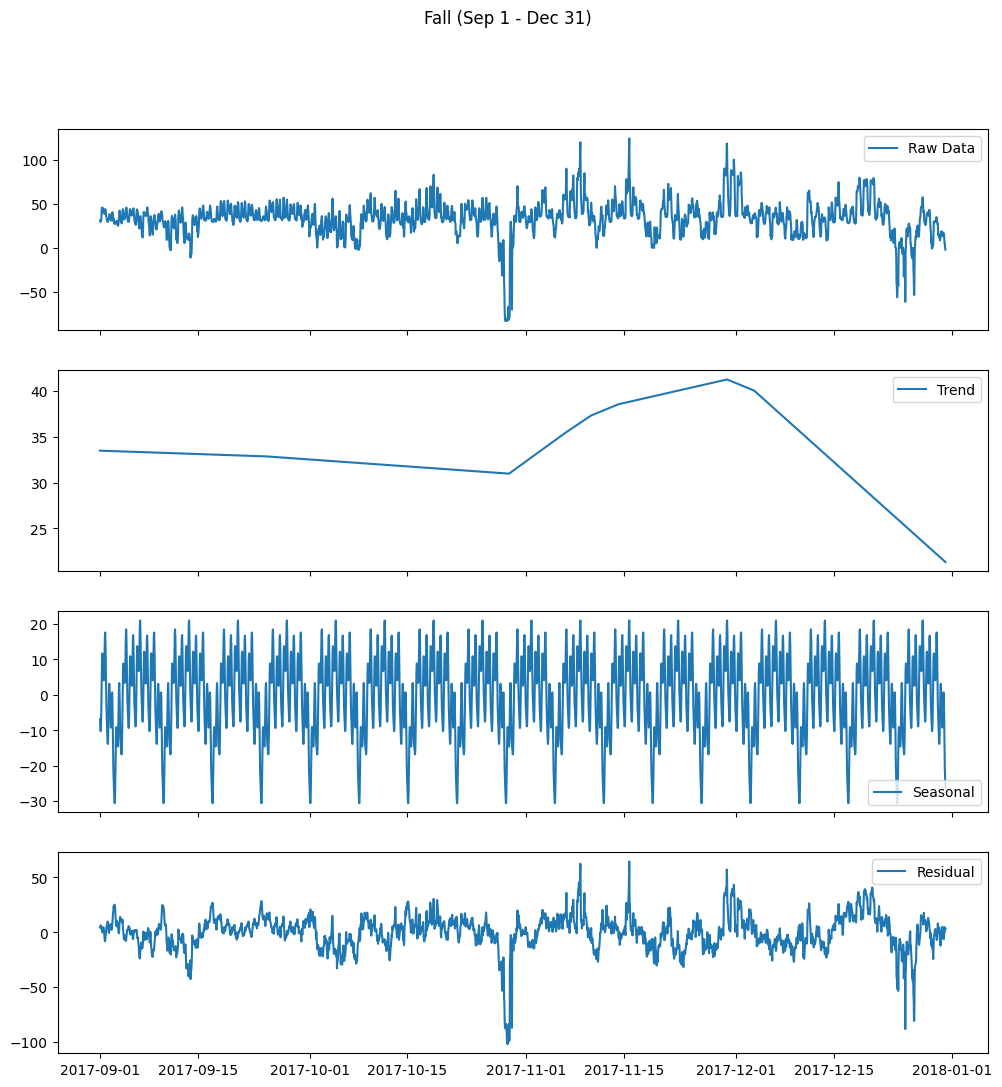

In [90]:
df_p = pd.DataFrame({
    'ds': pd.date_range('2017-09-01', periods=2928, freq='H'),
    'y': fall.values
})

model = Prophet()
model.fit(df_p)

future = model.make_future_dataframe(periods = 2928)

forecast = model.predict(future)

components = forecast[['ds', 'yhat', 'trend', 'additive_terms']]

start_date = '2017-09-01'
end_date = '2017-12-31'

forecast_2017 = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
df_p_2017 = df_p[(df_p['ds'] >= start_date) & (df_p['ds'] <= end_date)]

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex = True)

ax[0].plot(df_p_2017['ds'], df_p_2017['y'], label = 'Raw Data')
ax[0].legend()

ax[1].plot(forecast_2017['ds'], forecast_2017['trend'], label = 'Trend')
ax[1].legend()

ax[2].plot(forecast_2017['ds'], forecast_2017['additive_terms'], label = 'Seasonal')
ax[2].legend()

hist_forecast = forecast_2017[:len(df_p)]
residuals = df_p_2017['y'].values - hist_forecast['yhat']
ax[3].plot(df_p_2017['ds'], residuals, label = 'Residual')
ax[3].legend()
plt.suptitle("Fall (Sep 1 - Dec 31)")

plt.show()

09:31:08 - cmdstanpy - INFO - Chain [1] start processing
python(62457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
09:31:08 - cmdstanpy - INFO - Chain [1] done processing


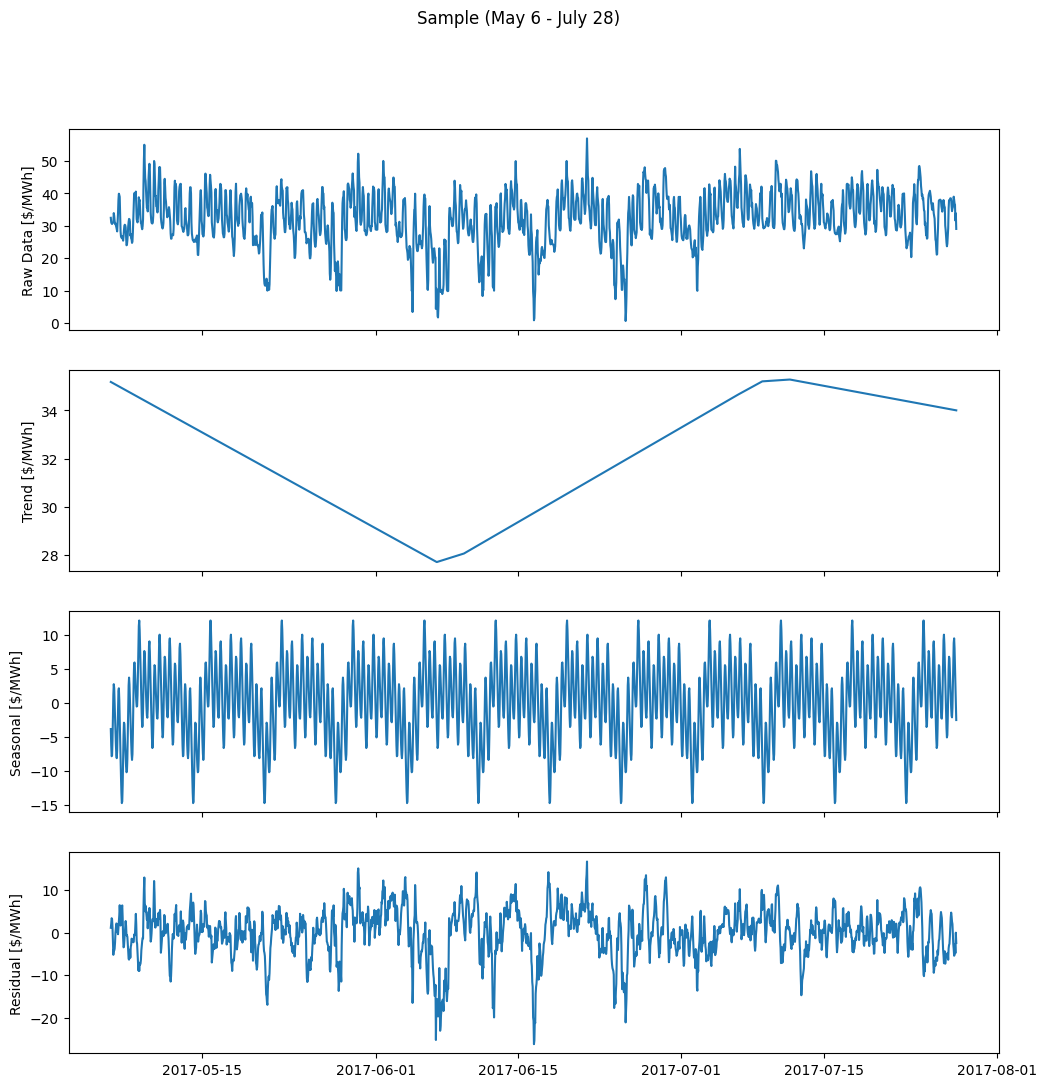

In [93]:
#STL on training data
sample = df['2017'][3000:5000]
df_p = pd.DataFrame({
    'ds': pd.date_range('2017-05-06', periods=2000, freq='H'),
    'y': sample.values
})

model = Prophet()
model.fit(df_p)

future = model.make_future_dataframe(periods = 2000)

forecast = model.predict(future)

components = forecast[['ds', 'yhat', 'trend', 'additive_terms']]

start_date = '2017-05-06'
end_date = '2017-07-28'

forecast_2017 = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
df_p_2017 = df_p[(df_p['ds'] >= start_date) & (df_p['ds'] <= end_date)]

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex = True)

ax[0].plot(df_p_2017['ds'], df_p_2017['y'], label = 'Raw Data')
ax[0].set_ylabel("Raw Data [$/MWh]")
#ax[0].legend()


ax[1].plot(forecast_2017['ds'], forecast_2017['trend'], label = 'Trend')
ax[1].set_ylabel("Trend [$/MWh]")
#ax[1].legend()

ax[2].plot(forecast_2017['ds'], forecast_2017['additive_terms'], label = 'Seasonal')
ax[2].set_ylabel("Seasonal [$/MWh]")
#ax[2].legend()

hist_forecast = forecast_2017[:len(df_p)]
residuals = df_p_2017['y'].values - hist_forecast['yhat']
ax[3].plot(df_p_2017['ds'], residuals, label = 'Residual')
ax[3].set_ylabel("Residual [$/MWh]")
#ax[3].legend()
plt.suptitle("Sample (May 6 - July 28)")
plt.savefig("STL", dpi = 400)
plt.show()